In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

In [2]:
data = pd.read_csv("../data/iris_data.csv", header=None)

In [3]:
data

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Splitting the dataset into X and Y variables

In [4]:
X_train, y_train = data[[0, 1, 2, 3]], data[4]

In [5]:
print(X_train, y_train)
print(X_train.shape, y_train.shape)

       0    1    2    3
0    5.1  3.5  1.4  0.2
1    4.9  3.0  1.4  0.2
2    4.7  3.2  1.3  0.2
3    4.6  3.1  1.5  0.2
4    5.0  3.6  1.4  0.2
..   ...  ...  ...  ...
145  6.7  3.0  5.2  2.3
146  6.3  2.5  5.0  1.9
147  6.5  3.0  5.2  2.0
148  6.2  3.4  5.4  2.3
149  5.9  3.0  5.1  1.8

[150 rows x 4 columns] 0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: 4, Length: 150, dtype: object
(150, 4) (150,)


Standardizing the training data:

In [6]:
mu = X_train.mean(axis=0)
sigma  = X_train.std(axis=0)

X_train = (X_train - mu) / sigma

In [7]:
X_train

,0,1,2,3
0,-0.897674,1.028611,-1.336794,-1.308593
1,-1.139200,-0.124540,-1.336794,-1.308593
2,-1.380727,0.336720,-1.393470,-1.308593
3,-1.501490,0.106090,-1.280118,-1.308593
4,-1.018437,1.259242,-1.336794,-1.308593
...,...,...,...,...
145,1.034539,-0.124540,0.816888,1.443121
146,0.551486,-1.277692,0.703536,0.918985
147,0.793012,-0.124540,0.816888,1.050019
148,0.430722,0.797981,0.930239,1.443121


In [8]:
y_train = y_train.replace({
  "Iris-setosa": 0,
  "Iris-versicolor": 1,
  "Iris-virginica": 2
}).astype(int)

/var/folders/rk/_r6t3b5j0jd1cjytp0py3tv00000gn/T/ipykernel_21305/445551901.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace({


In [9]:
y_train

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: 4, Length: 150, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

Y_onehot = pd.get_dummies(y_train).reindex(columns=[0, 1, 2], fill_value=0).to_numpy()
Y_val_onehot = pd.get_dummies(y_val)

In [12]:
print(X_train, X_val, y_train, y_val, Y_onehot, Y_val_onehot, sep="\n")

            0         1         2         3
22  -1.501490  1.259242 -1.563497 -1.308593
15  -0.173094  3.104284 -1.280118 -1.046525
65   1.034539  0.106090  0.363481  0.263815
11  -1.259964  0.797981 -1.223442 -1.308593
42  -1.743017  0.336720 -1.393470 -1.308593
..        ...       ...       ...       ...
71   0.309959 -0.585801  0.136778  0.132781
106 -1.139200 -1.277692  0.420157  0.656917
14  -0.052331  2.181763 -1.450146 -1.308593
92  -0.052331 -1.047062  0.136778  0.001747
102  1.517592 -0.124540  1.213619  1.181053

[120 rows x 4 columns]
            0         1         2         3
73   0.309959 -0.585801  0.533509  0.001747
18  -0.173094  1.720502 -1.166767 -1.177559
118  2.242172 -1.047062  1.780377  1.443121
78   0.189196 -0.355171  0.420157  0.394849
76   1.155302 -0.585801  0.590184  0.263815
31  -0.535384  0.797981 -1.280118 -1.046525
64  -0.293857 -0.355171 -0.089926  0.132781
141  1.276066  0.106090  0.760212  1.443121
68   0.430722 -1.969583  0.420157  0.394849
82  -0.0

In [13]:
num_features = X_train.shape[1]
num_classes = 3

W = np.zeros((num_features, num_classes))
b = np.zeros((1, num_classes))

In [14]:
def compute_logits(X, W, b):
  return np.dot(X, W) + b

In [15]:
def softmax(z):
  exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
  return exp_z / np.sum(exp_z, axis=1, keepdims=True)

### Cross-Entropy Loss

For multi-class classification with one-hot encoded labels, the cross-entropy loss is defined as:

$$
\mathcal{L} = -\frac{1}{m} \sum_{i=1}^{m} \sum_{j=1}^{C} y_{ij} \cdot \log(\hat{y}_{ij})
$$

Where:
- \( m \) is the number of samples  
- \( C \) is the number of classes  
- \( y_{ij} \) is the true one-hot encoded label (1 if sample \( i \) belongs to class \( j \), otherwise 0)  
- \( \hat{y}_{ij} \) is the predicted probability for sample \( i \), class \( j \)


In [16]:
def cross_entropy_loss(Y_pred, Y_true):
  m = Y_true.shape[0]
  return -np.sum(Y_true * np.log(Y_pred * 1e-15)) / m

In [17]:
def compute_gradients(X, Y_true, Y_pred):
  m = X.shape[0]
  dZ = Y_pred - Y_true
  dW = np.dot(X.T, dZ) / m
  db = np.sum(dZ, axis=0, keepdims=True)
  return dW, db


In [19]:
learning_rate = 0.1
epochs = 1000
losses = []

for epoch in range(epochs):
  logits = compute_logits(X_train, W, b)
  Y_pred = softmax(logits)
  loss = cross_entropy_loss(Y_pred, Y_onehot)
  losses.append(loss)
  dW, db = compute_gradients(X_train, Y_onehot, Y_pred)


  W -= learning_rate * dW
  b -= learning_rate * db

  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.4f}")


Epoch: 0, Loss: 35.6374
Epoch: 100, Loss: 35.1391
Epoch: 200, Loss: 34.8950
Epoch: 300, Loss: 34.7522
Epoch: 400, Loss: 34.6939
Epoch: 500, Loss: 34.6795
Epoch: 600, Loss: 34.6689
Epoch: 700, Loss: 34.6606
Epoch: 800, Loss: 34.6539
Epoch: 900, Loss: 34.6484


In [20]:
def predict(X, W, b):
  logits = compute_logits(X, W, b)
  probs = softmax(logits)
  return np.argmax(probs, axis=1)

In [ ]:
y_pred_labels = predict(X_train, W, b)
training_accuracy = np.mean(y_pred_labels == y_train.to_numpy())
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")

Training Accuracy: 96.67%


In [25]:
y_pred_validation_labels = predict(X_val, W, b)
validation_accuracy = np.mean(y_pred_validation_labels == y_val.to_numpy())
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

Validation Accuracy: 100.00%


Text(0.5, 1.0, 'Training Loss Curve')

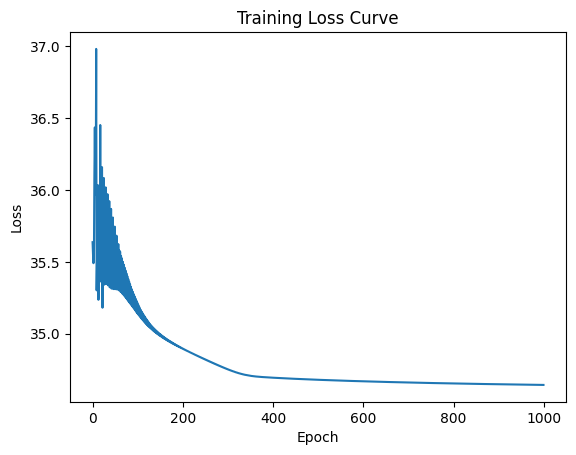

In [22]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")